## Text Mining from Twitter tweets

- Connect to the Twitter API
- Conditioned on region, keywords:'keto', 'keto diet', 'keto beverage', 'keto drinks', 'keto snacks'

In [349]:
import tweepy as tw
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings("ignore")


In [56]:
#Variables that contains the user credentials to access Twitter API 
access_token = "1120245592708538368-A7MFOXpqB5LglqLJYq5lptoKjO1aiC"
access_token_secret = "v09lnFfGqrCHso0JKzKtTdbzWo1AzeqgYhoUR50Z5nwGg"
consumer_key = "hScE32UwDNeVZ8Tu9MvUUTziL"
consumer_secret = "SPiGlQDXmtaLOSMCF2v50h5nzK9aHE7qURRjSPaz9ieVIOx0zh"

auth =tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [120]:
search_words=['#keto' , '#ketodiet', '#ketosnacks', '#ketofood','#ketobeverage']
date_since='2019-04-16'
idx=0

In [314]:
tweets=tw.Cursor(api.search,
                 q='keto OR ketodiet OR ketosnacks OR ketofood OR ketobeverage -filter:retweets',
                 lang='en',since=date_since).items(2000)

In [305]:
#tweet.retweets()[2].text

In [315]:
text_df=pd.DataFrame(columns=['time','text'])
hashtags_dict={}

In [316]:
def ziphashtag(tw,hashtags_dict):
    for tag in tw.entities['hashtags']:
        if tag['text'] in hashtags_dict.keys():
            hashtags_dict[tag['text']]+=1
        else:
            hashtags_dict[tag['text']]=1
    return hashtags_dict

In [317]:
text_df.loc[len(text_df),['time','text']]=tweet.created_at,tweet.text

In [318]:
for tweet in tweets:
    text_df.loc[len(text_df),['time','text']]=tweet.created_at,tweet.text
    hashtags_dict=ziphashtag(tweet,hashtags_dict)

In [322]:
text_df.head()

,time,text
0,2019-04-19 11:46:57,"Keto Wine, Anyone? 🍷🍾 + Lolli’s Low Carb Grano..."
1,2019-04-22 11:42:55,Sitting on the patio enjoying my Keto Coffee a...
2,2019-04-22 11:42:26,@ItsSempleAsThat Did keto work for you?
3,2019-04-22 11:41:52,Keto Raspberry Cookies Recipe https://t.co/4BQ...
4,2019-04-22 11:40:27,Give this a share if you like it. Keto Diet Lo...


In [342]:
hash_df=pd.DataFrame(hashtags_dict.items(),columns=['hashtag','numbers'])

In [346]:
hash_df.head()

,hashtag,numbers
0,Easter,5
1,GameofThrones,2
2,lowcarb,71
3,diabetes,3
4,typeonegrit,1


### Word Frequency Counts
- Crean the Tweets Text
    - Remove URL
    - Remove the differences in case
    - Remove search keywords
    - Remove the stop word
- Summarize and count words found

In [356]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    txt : string
        A text string that you want to parse and remove urls.
    Returns:
    The same txt string with url's removed.
    """
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split()).lower()

In [357]:
text_df['text']=text_df['text'].apply(remove_url,)

In [359]:
text_df.head()

,time,text
0,2019-04-19 11:46:57,keto wine anyone lollis low carb granola is 20...
1,2019-04-22 11:42:55,sitting on the patio enjoying my keto coffee a...
2,2019-04-22 11:42:26,itssempleasthat did keto work for you
3,2019-04-22 11:41:52,keto raspberry cookies recipe
4,2019-04-22 11:40:27,give this a share if you like it keto diet lon...


In [388]:
words=pd.Series(' '.join(text_df['text']).split()).value_counts()

In [407]:
words.head(10)

keto    1646
the      685
and      602
i        580
to       556
a        542
diet     419
for      364
on       359
is       359
dtype: int64

In [370]:
#Remove Stopwords and Search Keywords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/surichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [419]:
stop_words = set(stopwords.words('english'))

In [432]:
stop_words.remove('don\'t')
stop_words.add('keto')

In [433]:
text_df['text'] = text_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [434]:
words_cl=pd.Series(' '.join(text_df['text']).split()).value_counts().head(30)

Text(0.5, 1.0, 'Common Words Found in Tweets (Without Stop or Collection Words)')

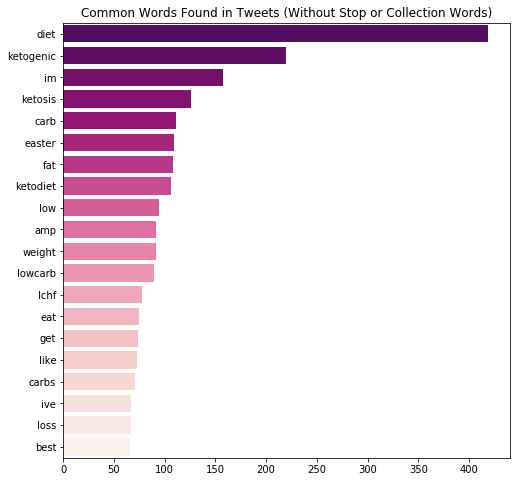

In [442]:
fig,ax=plt.subplots(figsize=(8,8))
ax=sns.barplot(y=words_cl.index[:20],x=words_cl[:20],palette='RdPu_r')
ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

In [443]:
# Explore Co-occuring Words- Bigrams

In [464]:
# Create list of lists containing bigrams in tweets
terms_bigram = [ list(nltk.bigrams(tweet.split())) for tweet in text_df['text']]

# View bigrams for the first tweet
terms_bigram[0]

[('wine', 'anyone'),
 ('anyone', 'lollis'),
 ('lollis', 'low'),
 ('low', 'carb'),
 ('carb', 'granola'),
 ('granola', '20'),
 ('20', 'offtoday')]

In [469]:
bigrams = list(itertools.chain(*terms_bigram))
bigram_counts = collections.Counter(bigrams)

In [473]:
bigram_counts.most_common(20)

[(('low', 'carb'), 82),
 (('ketogenic', 'diet'), 81),
 (('diet', 'ketosis'), 55),
 (('ketogenic', 'ketosis'), 45),
 (('weight', 'loss'), 44),
 (('ketosis', 'lchf'), 41),
 (('ketosis', 'inspiration'), 34),
 (('happy', 'easter'), 34),
 (('lchf', 'ketodiet'), 29),
 (('best', 'diet'), 24),
 (('via', 'youtube'), 22),
 (('ketosis', 'motivation'), 21),
 (('fat', 'loss'), 21),
 (('ketodiet', 'best'), 20),
 (('diet', 'fat'), 20),
 (('loss', 'available'), 20),
 (('fat', 'ketogenic'), 16),
 (('lose', 'weight'), 15),
 (('via', 'rketo'), 14),
 (('shark', 'tank'), 14)]

### Summary:
- From the twitter post, keto diet is related to 'low carb', 'lchf diet', 'fat loss'. In terms of food, people are going for low carb, high fat, plant-based food, added-suger and starchy foods are restricted from the meal plan. Which meets the core reqiurement of keto diet. 
- However, the topics related to beverage and drinks are limited, might be an interesting aspect to be digged into.